In [13]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .getOrCreate()

In [60]:
from pyspark.sql.functions import col, log10

df = spark.read.load('/data/kc_house_data.csv', format='csv', header=True, inferSchema=True)

df = df.withColumn("price", col("price").cast("float"))

print("Number of rows loaded: %d" % df.count())

df.printSchema()

Number of rows loaded: 21613
root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: float (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [40]:
df.show(n=1)

+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
+----------+---------------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+---

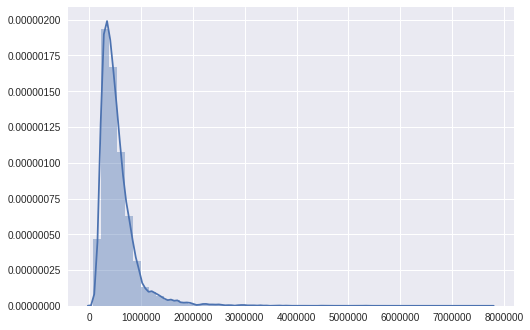

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

prices = df.select('price')
sns.distplot(prices.toPandas());
plt.show()

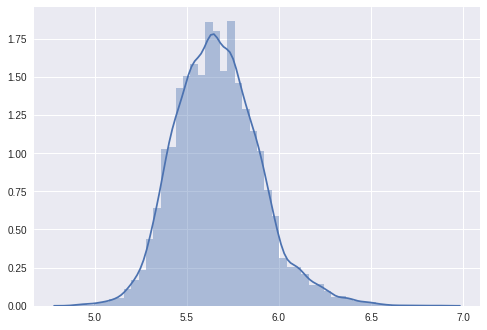

In [63]:
prices = df.select(log10(col('price')))
sns.distplot(prices.toPandas());
plt.show()

In [80]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition",
               "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated"],
    outputCol="features")

df_ml = assembler.transform(df).select("features", "price")

df_ml = df_ml.withColumn("price_log10", log10(col("price")))

df_ml.show(n=1)

+--------------------+--------+-----------------+
|            features|   price|      price_log10|
+--------------------+--------+-----------------+
|[3.0,1.0,1180.0,5...|221900.0|5.346157302232008|
+--------------------+--------+-----------------+
only showing top 1 row



In [81]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(regParam=5.0, labelCol="price_log10")

model = lr.fit(df_ml)

In [82]:
print(model.coefficients)

[0.00310818340735,0.00618616334634,6.70419674544e-06,2.02766384922e-08,0.00492776033161,0.0184147093358,0.00412161216617,0.000800346453944,0.00540476265212,6.3745812263e-06,6.55499532214e-06,1.22688594895e-05,2.69481107688e-06]


In [83]:
print(model.intercept)

5.53848407820077


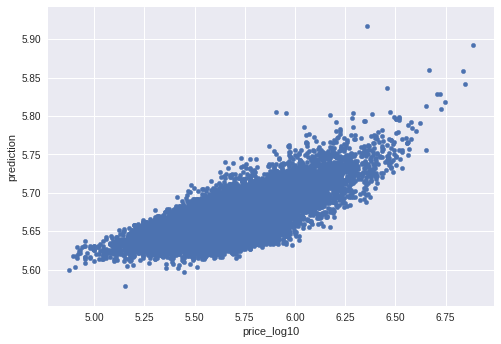

In [86]:
pred = model.transform(df_ml)
pred.select('price_log10', 'prediction').toPandas().plot(x='price_log10', y='prediction', kind='scatter')
plt.show()

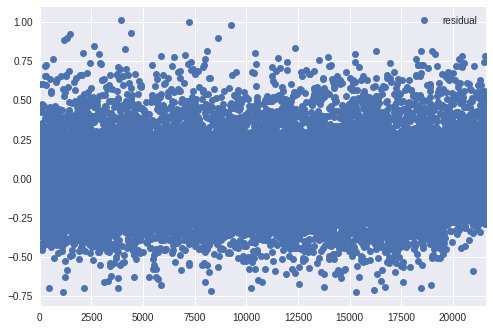

In [87]:
residuals = pred.withColumn("residual", col("price_log10") - col("prediction"))
residuals.select('residual').toPandas().plot(y='residual', style='o')
plt.show()

In [92]:
from pyspark.mllib.evaluation import RegressionMetrics

metrics = RegressionMetrics(pred.select('prediction', 'price_log10').rdd)

print(metrics.r2)

0.15269929414867023
